In [70]:
import pandas as pd
import xarray as xr
import random
from river_dl.loss_functions import rmse
import matplotlib.pyplot as plt

In [4]:
ds = xr.open_zarr("../../out/well_obs_io.zarr/")

In [16]:
rand_rep_id = random.randint(0, 9)

In [17]:
pred_path = "{model_id}/nstates_10/nep_100/rep_{rep_id}/val_preds.feather"

In [73]:
val_sites = ["01472104", "01473500", "01481500"]

In [74]:
df_obs = ds[['do_min', 'do_max']].to_dataframe()

In [75]:
df_obs['do_range'] = df_obs['do_max'] - df_obs['do_min']
df_obs['model_id'] = 'obs'

In [20]:
model_ids = ["0_baseline_LSTM", "1_metab_multitask", "1a_multitask_do_gpp_er", "2_multitask_dense"]

In [76]:
df_dict = {}
for model_id in model_ids:
    model_pred_path = pred_path.format(model_id=model_id, rep_id=rand_rep_id)
    df_preds = pd.read_feather(model_pred_path)
    df_preds['model_id'] = model_id.split("_")[0]
    df_preds["do_range"] = df_preds["do_max"] - df_preds["do_min"]
    combined = df_obs.join(df_preds.set_index(['date', 'site_id']), rsuffix="_preds", lsuffix="_obs").dropna()
    df_dict[model_id] = combined

In [89]:
rmse_dict = {}
for model_id, df in df_dict.items():
    rmse_dict[model_id] = rmse(df['do_range_obs'], df['do_range_preds']).numpy()

In [80]:
rmse_dict

{'0_baseline_LSTM': 1.8512985,
 '1_metab_multitask': 1.9639313,
 '1a_multitask_do_gpp_er': 2.028654,
 '2_multitask_dense': 1.8172861}

In [90]:
def calc_rmse(df):
    return rmse(df['do_range_obs'], df['do_range_preds']).numpy()

In [91]:
rmse_site_dict = {}
for model_id, df in df_dict.items():
    rmse_site_dict[model_id] = df.groupby('site_id').apply(calc_rmse)

In [92]:
rmse_site_dict

{'0_baseline_LSTM': site_id
 01472104    1.709284
 01473500    1.242241
 01480617    0.939116
 01480870    1.094907
 01481000    1.067019
 01481500    2.318757
 dtype: float64,
 '1_metab_multitask': site_id
 01472104    2.025928
 01473500    1.475443
 01480617    1.161701
 01480870    1.091684
 01481000    1.051365
 01481500    2.200476
 dtype: float64,
 '1a_multitask_do_gpp_er': site_id
 01472104    1.805939
 01473500    1.291599
 01480617    1.020819
 01480870    0.917993
 01481000    0.926462
 01481500    2.633141
 dtype: float64,
 '2_multitask_dense': site_id
 01472104    1.772016
 01473500    1.310759
 01480617    1.309248
 01480870    1.168449
 01481000    0.973595
 01481500    2.140906
 dtype: float64}

<AxesSubplot:xlabel='site_id'>

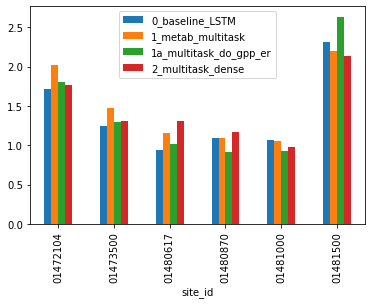

In [95]:
pd.DataFrame(rmse_site_dict).plot.bar()

In [36]:
site = "01481500"

In [37]:
df_obs_site = df_obs[df_obs['site_id'] == site]

<AxesSubplot:xlabel='date'>

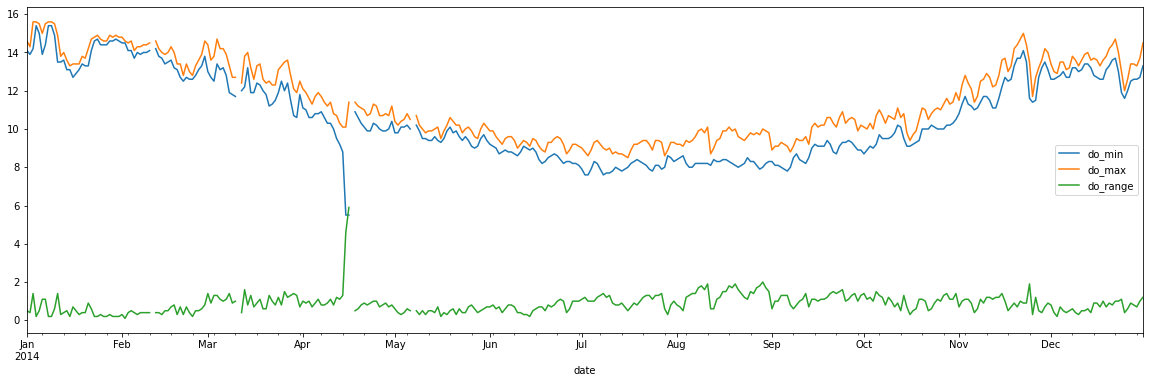

In [97]:
df_obs_site.set_index('date').loc["2014"][['do_min', 'do_max', 'do_range']].plot(figsize=(20,6))

<AxesSubplot:xlabel='date'>

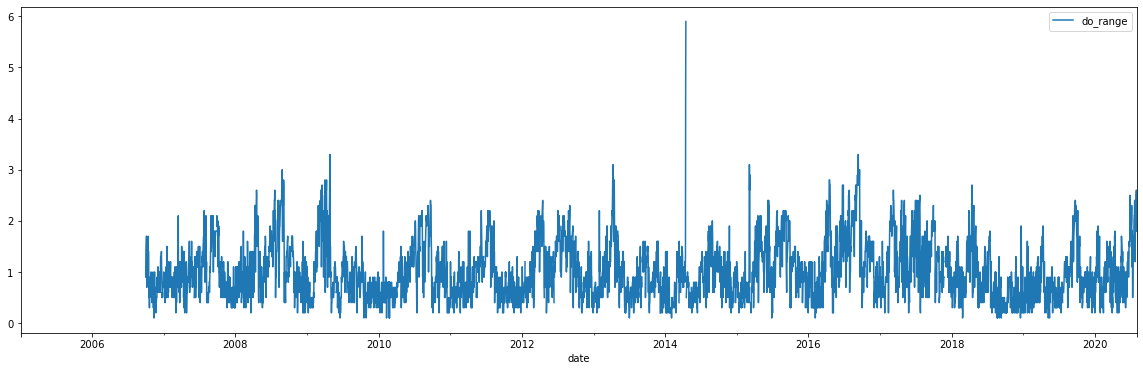

In [44]:
df_obs_site.set_index('date').loc["2005":][['do_range']].plot(figsize=(20,6))

In [68]:
combined = df_obs.set_index(['date', 'site_id']).join(df_preds.set_index(['date', 'site_id']), rsuffix="_preds", lsuffix="_obs")
combined = combined.dropna()

In [69]:
rmse(combined['do_range_obs'], combined['do_range_preds'])

<tf.Tensor: shape=(), dtype=float32, numpy=1.8172861>

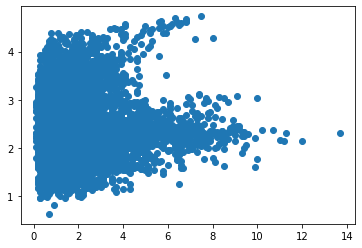

In [71]:
plt.scatter(combined['do_range_obs'], combined['do_range_preds'])